In this notebook we'll explore the solution found by our classifier.

In [32]:
from __future__ import print_function

import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pickle

from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model

import utils
import rnn

%load_ext autoreload
%matplotlib inline

ImportError: cannot import name divide

In [68]:
%autoreload
import utils
import rnn

### Re-create the training data using saved model params

In [3]:
# Pick a model to load and extract the hyperparams.

model_name = 'models/256_256_256_0.5_False_20_6747_0.0_64_0.0_1_32_titles_005_0.70946_0.42942_titles.h5'

gru_dim, embed_dim, dense_dim, dropout, bidirectional, maxlen, topn, test_size, batch_size = \
  utils.parse_model_name(model_name)

In [4]:
%%time

# Load the keras model
model = load_model(model_name)

CPU times: user 3.94 s, sys: 127 ms, total: 4.06 s
Wall time: 4.03 s


In [5]:
%%time

# Load the source data frame

filepath = '../data/data-True-0.pkl'
df, keep_stops, min_sents, vocab, w2i, i2w = utils.read_dataset(filepath)

CPU times: user 3.1 s, sys: 73 ms, total: 3.17 s
Wall time: 3.17 s


In [6]:
%%time

# Filter out uncommon words using parameters parsed from model name.

df['encoded_text'] = utils.filter_top_words(df['encoded_text'].tolist(), topn)

CPU times: user 298 ms, sys: 5.32 ms, total: 303 ms
Wall time: 307 ms


In [7]:
# Create input/output data

X = pad_sequences(df['encoded_text'], maxlen=maxlen, value=topn, 
                  padding='post', truncating='post')

Y = df['encoded_label'].tolist()

In [8]:
%%time

# Get output probabilities for every observation.

Ypred = model.predict(X)

CPU times: user 2min 57s, sys: 15.7 s, total: 3min 12s
Wall time: 34.4 s


In [12]:
df['predicted_label'] = model.predict_classes(X)

66656/66659 [============================>.] - ETA: 0s 

In [13]:
df['predicted_prob'] = np.max(Ypred, axis=1)

In [120]:
hi = pd.DataFrame(df[df['predicted_prob'] > 0.9])
hi.shape

(16593, 9)

In [121]:
conf_thresh = 0.10

counts_hi = pd.DataFrame(hi['domain'].value_counts(), dtype=float)
counts_all = pd.DataFrame(df['domain'].value_counts())

for row in counts_hi.iterrows():
  counts_hi.ix[row[0]] /= counts_all.ix[row[0]]
  
counts_hi = counts_hi.sort_values('domain', ascending=False)
counts_hi = counts_hi[counts_hi['domain'] > conf_thresh]
counts_hi

,domain
ap.org,1.000000
americanthinker.com,0.998652
realclearpolitics.com,0.997003
rightwingnews.com,0.992784
westernjournalism.com,0.616837
breitbart.com,0.589195
go.com,0.435010
cnn.com,0.266824
washingtonpost.com,0.258809
nytimes.com,0.248451


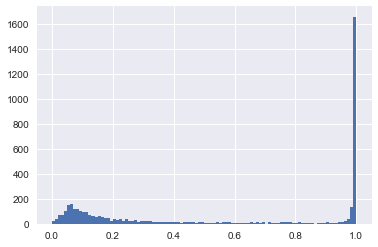

In [91]:
def plot_domain_scores(df, Y, domain, thresh=0.9):
    domain_idx = np.where(df['domain'] == domain)[0]
    if len(domain_idx) == 0:
        print('none found')    
        return
    df = pd.DataFrame(df.iloc[domain_idx, :])
    Y = Y[domain_idx, :]
    
    col_idx = df['encoded_label'].iloc[0]
    Y = Y[:, col_idx]
    
    row_idx = np.where(Y > thresh)[0]
    Y = Y[row_idx]
    df = pd.DataFrame(df.iloc[row_idx, :])
    
    df['probs'] = Y
    ax = df['probs'].hist(bins=100)
    
    return df, ax

_ = plot_domain_scores(df, Ypred, 'go.com', thresh=0.)

In [92]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 256)           1727488   
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               393984    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                8224      
Total params: 2,195,488
Trainable params: 2,195,488
Non-trainable params: 0
_________________________________________________________________


In [93]:
%autoreload
import utils
import rnn

in_model = rnn.split_model_layers(model, topn, embed_dim, dense_dim, gru_dim, 1, maxlen, Ypred.shape[1], bidirectional)
in_model.layers[1].set_weights(model.layers[1].get_weights())
in_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 256)           1727488   
_________________________________________________________________
gru_2 (GRU)                  (None, 20, 256)           393984    
_________________________________________________________________
dense_3 (Dense)              (None, 20, 256)           65792     
_________________________________________________________________
dense_4 (Dense)              (None, 20, 32)            8224      
Total params: 2,195,488
Trainable params: 2,195,488
Non-trainable params: 0
_________________________________________________________________


In [124]:
hi[hi['domain'] == 'cnn.com']

,title,label,url,domain,tokenized,encoded_text,encoded_label,predicted_label,predicted_prob
9,TV war over Obamacare 'still needs time to dev...,liberal,http://www.cnn.com/2017/03/09/politics/obamaca...,cnn.com,tv_NOUN war_NOUN over_ADP obamacare_PROPN stil...,"[590, 444, 41, 50, 170, 364, 132, 4, 4245]",6,6,0.972764
24,Poachers killed rare rhinoceros in French zoo ...,liberal,http://www.cnn.com/videos/world/2017/03/09/par...,cnn.com,poacher_NOUN kill_VERB rare_ADJ rhinoceros_NOU...,"[6409, 60, 2173, 2, 1432, 2297, 43, 55]",6,6,0.999931
40,Van Jones: There is a danger normalizing Trump...,liberal,http://www.cnn.com/videos/politics/2017/03/09/...,cnn.com,van_PROPN jones_PROPN there_ADV be_VERB a_DET ...,"[2515, 1722, 241, 5, 10, 3043, 0, 43, 55]",6,6,0.999999
139,HHS doctor publicly comes out against GOP's he...,liberal,http://www.cnn.com/2017/03/09/politics/medicai...,cnn.com,hhs_PROPN doctor_NOUN publicly_ADV come_VERB o...,"[1582, 770, 5405, 120, 93, 64, 47, 72, 89, 82]",6,6,0.950591
170,Barton: 'I will buy Waffle House for everyone'...,liberal,http://www.cnn.com/videos/politics/2017/03/09/...,cnn.com,barton_PROPN -PRON-_PRON will_VERB buy_VERB wa...,"[6, 30, 960, 24, 7, 813, 115, 6, 187, 2113, 43...",6,6,0.999996
177,NYT columnist calls Trump a pathological liar ...,liberal,http://www.cnn.com/videos/politics/2017/03/08/...,cnn.com,nyt_PROPN columnist_NOUN call_VERB trump_PROPN...,"[1079, 4803, 66, 0, 10, 5981, 43, 55]",6,6,0.999950
181,Dave Chappelle crashes town hall - CNN Video,liberal,http://www.cnn.com/videos/politics/2017/03/09/...,cnn.com,dave_PROPN chappelle_PROPN crash_VERB town_NOU...,"[3915, 6582, 1261, 499, 1082, 43, 55]",6,6,0.999984
195,Ethics office rebukes White House over Kellyan...,liberal,http://money.cnn.com/2017/03/09/news/ethics-of...,cnn.com,ethics_PROPN office_NOUN rebuke_VERB white_PRO...,"[1658, 410, 3606, 32, 24, 41, 315, 181, 184, 0]",6,6,0.946452
216,Tapper: Not even Trump's team believes claims ...,liberal,http://www.cnn.com/videos/politics/2017/03/09/...,cnn.com,tapper_NOUN not_ADV even_ADV trump_PROPN team_...,"[4856, 36, 375, 0, 292, 721, 202, 43, 55]",6,6,0.999993
224,EPA chief: Carbon dioxide not 'primary contrib...,liberal,http://www.cnn.com/2017/03/09/politics/scott-p...,cnn.com,epa_PROPN chief_NOUN carbon_NOUN dioxide_NOUN ...,"[346, 446, 2996, 36, 4306, 6248, 4, 298]",6,6,0.945223


In [126]:
def display(idx):
  P = in_model.predict(X[idx:(idx+1), :]).squeeze()
  z = zip(P[:, df['encoded_label'].iloc[idx]], df['tokenized'].iloc[idx].split())
  print(df['domain'].iloc[idx])
  _ = map(print, z)
  return z

idx = np.where(df.index == 67261)[0][0]
_ = display(idx)

cnn.com
(0.19444419, u'angelina_PROPN')
(0.41011295, u'jolie_PROPN')
(0.077014819, u'open_VERB')
(0.018144559, u'up_PART')
(0.060277302, u'about_ADP')
(0.93689305, u'-PRON-_ADJ')
(0.99982148, u'divorce_NOUN')
(0.99995518, u'cnn_PROPN')
(0.99997997, u'video_PROPN')


In [116]:
from collections import defaultdict

def get_hival_tokens(domain, domain_thresh=0.9, token_thresh=0.9):
  hi = pd.DataFrame(df[df['domain'] == domain])
  hi = pd.DataFrame(hi[hi['encoded_label'] == hi['predicted_label']])
  hi = pd.DataFrame(hi[hi['predicted_prob'] > domain_thresh])
  tokens = defaultdict(float)
  for row in hi.iterrows():
    idx = np.where(df.index == row[0])[0][0]
    P = in_model.predict(X[idx:(idx+1), :]).squeeze()
    T = df['tokenized'].iloc[idx].split()
    hival_idx = np.where(P > token_thresh)[0]
    for i in hival_idx:
      if i >= len(T):
        break
      tokens[T[i]] += 1
  
  for k in tokens:
    tokens[k] = 1. * tokens[k] / hi.shape[0]
  
  return hi, tokens

def create_blacklist(hi_thresh=0.2, domain_prob=0.9, domain_thresh=0.9, token_thresh=0.9, count_thresh=0.2):
  hi = pd.DataFrame(df[df['predicted_prob'] > hi_thresh])

  counts_hi = pd.DataFrame(hi['domain'].value_counts(), dtype=float)
  counts_all = pd.DataFrame(df['domain'].value_counts())

  for row in counts_hi.iterrows():
    counts_hi.ix[row[0]] /= counts_all.ix[row[0]]

  counts_hi = counts_hi.sort_values('domain', ascending=False)
  counts_hi = counts_hi[counts_hi['domain'] > domain_prob]
  
  blacklist = {}
  for domain in counts_hi.index:
    print(domain)
    hi, tokens = get_hival_tokens(domain)
    counts = [(v, k) for k,v in tokens.iteritems()]
    blacklist[domain] = [x[1] for x in counts if x[0] >= count_thresh]
    print('  {}'.format(blacklist[domain]))

  return blacklist

In [117]:
%%time

blacklist = create_blacklist()

rightwingnews.com
  [u'wing_PROPN', u'news_PROPN', u'hawkins_PROPN', u'john_PROPN', u'right_PROPN']
americanthinker.com
  [u'article_NOUN', u'the_DET', u'of_ADP']
ap.org
  [u'press_PROPN', u'associated_PROPN']
realclearpolitics.com
  [u'realclearpolitic_NOUN']
cnn.com
  [u'video_PROPN', u'cnn_PROPN']
nytimes.com
  []
breitbart.com
  [u'breitbart_PROPN']
westernjournalism.com
  []
washingtonpost.com
  [u'-PRON-_PRON', u'opinion_NOUN', u'the_DET', u'a_DET', u'trump_PROPN', u'be_VERB']
go.com
  [u'in_ADP', u'video_NOUN']
wsj.com
  []
cbsnews.com
  [u'opener_PROPN', u'ftn_PROPN', u'page_NOUN', u'trump_PROPN', u'at_ADP']
usatoday.com
  [u'raw_ADJ']
newsmax.com
  [u'rove_PROPN', u'pathetic_ADJ', u'for_ADP', u'podesta_PROPN']
cnbc.com
  [u'the_DET']
theatlantic.com
  [u'politics_PROPN', u'policy_PROPN', u'the_DET', u'daily_PROPN', u'what_NOUN']
weeklystandard.com
  [u'and_CCONJ', u'the_DET', u'of_ADP']
CPU times: user 2min 41s, sys: 1min 35s, total: 4min 16s
Wall time: 1min 51s


In [115]:
black_list